<a href="https://colab.research.google.com/github/ToyosiAbu/VotingSystems/blob/main/MultiCategorySTARVotingSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Multi-Category STAR Voting System

A Python implementation of the STAR (Score Then Automatic Runoff) voting system, extended to handle multiple categories/races simultaneously.

##Features
- Individual STAR elections per category
- Overall winner determination across all categories
- Official tie-breaking procedures from STAR voting guidelines
- Comprehensive visualizations of results

## Use Cases
- Competition judging (baking, art, music, etc.)
- Multi-category elections\n",
- Any scenario requiring ranked voting across multiple dimensions

## About STAR Voting

STAR (Score Then Automatic Runoff) is an innovative voting system that combines the expressiveness of score voting with the majority-finding nature of runoff elections. Learn more at [starvoting.org](https://www.starvoting.org/).
      
This implementation extends the standard STAR system to handle multiple categories, making it perfect for competitions where contestants compete in different divisions.

## Inspiration
I was inspired to build this implementation while trying to judge a banana bread baking competition among friends. This notebook will reference baking and banana bread throughout the configurations and defaults - feel free to adapt it to your own needs!

In [47]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Configuration Constants"
DEFAULT_MAX_SCORE = 7
DEFAULT_SCORE_RANGE = (1, 7)
MEDAL_SYMBOLS = {'gold': '[1st]', 'silver': '[2nd]', 'bronze': '[3rd]'}
MEDAL_EMOJI = {'gold': '🥇', 'silver': '🥈', 'bronze': '🥉'}

# Set style for better looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Ballot Collection and Data Validation

### Test Data Generation
This section provides utilities to generate test ballot data for trying out the voting system. For me, the test ballot data simulates the results of a baking competition.

In [48]:
### Genenerate a test dataset.

def generate_test_ballots(n_ballots: int = 100,
                         contestants: List[str] = None,
                         race_categories: List[str] = None,
                         contestant_labels: List[str] = None,
                         score_range: Tuple[int, int] = DEFAULT_SCORE_RANGE,
                         participation_rate: float = 0.8,
                         n_voters: int = 20) -> pd.DataFrame:
    """
    Generate test ballot data for the voting system.

    Args:
        n_ballots (int): Number of ballots to generate.
        contestants (List[str]): List of contestant names.
        race_categories (List[str]): List of race categories.
        contestant_labels (List[str]): List of labels for entries.
        score_range (Tuple[int, int]): Min and max scores",
        participation_rate (float): Probability a contestant enters a category",
        n_voters (int): Number of voters"

    Returns:
        pd.DataFrame: Test ballot data with columns -
          [BallotID, Contestant, RaceCategory, ContestantLabel, Score]\n",

    """
    # Default Contestants (Baker names)
    if contestants is None:
        contestants = ["Hermann", "Olivia", "Sai", "Chaitra", "Toyosi"]

    # Default Categories (Bread types)
    if race_categories is None:
        race_categories = ["Normal", "Chocolate", "Fruit"]

    if contestant_labels is None:
        contestant_labels = [
            "Normal Banana Bread", "Rustic Banana Bread", "Artisan Special",
            "Homestyle", "Gourmet Edition", "Traditional Recipe"
        ]

    # Pre-assign one label per contestant-race combination
    contestant_race_labels = {}
    for race_category in race_categories:
        for contestant in contestants:
            if random.random() < participation_rate:
                contestant_race_labels[(contestant, race_category)] = random.choice(contestant_labels)

    # Ensure at least 3 contestants per race category
    for race_category in race_categories:
        participating_in_race = [c for c in contestants if (c, race_category) in contestant_race_labels]
        if len(participating_in_race) < 3:
            missing_contestants = [c for c in contestants if (c, race_category) not in contestant_race_labels]
            to_add = min(3 - len(participating_in_race), len(missing_contestants))
            for contestant in random.sample(missing_contestants, to_add):
                contestant_race_labels[(contestant, race_category)] = random.choice(contestant_labels)

    ballots = []
    min_score, max_score = score_range

    # Generate BallotIDs (voters)
    ballot_ids = [f"Voter_{i:03d}" for i in range(1, n_voters + 1)]

    # Track which contestant-race combinations each voter has already scored
    voter_scores = set()

    # Generate target number of ballots
    attempts = 0
    max_attempts = n_ballots * 3

    while len(ballots) < n_ballots and attempts < max_attempts:
        attempts += 1

        ballot_id = random.choice(ballot_ids)
        race_category = random.choice(race_categories)

        participating_contestants = [
            c for c in contestants
            if (c, race_category) in contestant_race_labels
        ]

        if not participating_contestants:
            continue

        available_contestants = [
            c for c in participating_contestants
            if (ballot_id, c, race_category) not in voter_scores
        ]

        if not available_contestants:
            continue

        contestant = random.choice(available_contestants)
        voter_scores.add((ballot_id, contestant, race_category))

        contestant_label = contestant_race_labels[(contestant, race_category)]

        # Generate realistic scores with some bias
        if random.random() < 0.1:  # 10% chance of very low score
            score = random.randint(min_score, min_score + 1)
        elif random.random() > 0.75:  # 25% chance of very high score
            score = random.randint(max_score - 1, max_score)
        else:  # 65% chance of middle range score
            score = random.randint(min_score + 1, max_score - 1)

        ballots.append({
            'BallotID': ballot_id,
            'Contestant': contestant,
            'RaceCategory': race_category,
            'ContestantLabel': contestant_label,
            'Score': score
        })

    df = pd.DataFrame(ballots)
    df = df.sample(frac=1).reset_index(drop=True)

    return df


### Reading CSV Data
And now for some real data. This section handles importing ballot data from CSV files and validating the data structure.

For my banana bread competition, I created a CSV specifically to parse the expected form of my ballot.

Feel free to skip this section if you're using your own data format.

In [49]:
def parse_banana_bread_csv(csv_path, max_score=DEFAULT_MAX_SCORE):
    """
    Parse CSV ballot data specifically for the Banana Bread Competition from Google Forms exports.
    Expects columns in the format: "[Contestant]'s [Label] (Category)"
    Uses row number as the voter ID.

    Args:
        csv_path (str): Path to the CSV file
        max_score (int): Maximum score to cap ratings at

    Returns:
        pd.DataFrame: Processed ballot data ready for STAR voting system
    """
    # Read the CSV file
    try:
        raw_df = pd.read_csv(csv_path)
        print(f"CSV loaded with {raw_df.shape[0]} rows and {raw_df.shape[1]} columns")
    except FileNotFoundError:
         print(f"❌ Error: Could not find file {csv_path})")
         return None
    except Exception as e:
        print(f"❌ Error reading CSV: {e}")
        return None

    # Get ballot columns (all except the first one, which is timestamp)
    ballot_columns = raw_df.columns[1:]
    print(f"Found {len(ballot_columns)} ballot columns")

    # Regular expression to parse column headers in the format: "[Contestant]'s [Label] (Category)"
    pattern = r"([^']+)'s\s+([^(]+)\s*\(([^)]+)\)"

    processed_ballots = []
    column_parsing_results = []

    # First, parse and validate all column headers
    for col in ballot_columns:
        match = re.match(pattern, col)
        if match:
            contestant = match.group(1).strip()
            contestant_label = match.group(2).strip()
            race_category = match.group(3).strip()
            column_parsing_results.append({
                'column': col,
                'valid': True,
                'contestant': contestant,
                'label': contestant_label,
                'category': race_category
            })
        else:
            print(f"Warning: Column '{col}' does not match expected format '[Contestant]'s [Label] (Category)'")
            column_parsing_results.append({
                'column': col,
                'valid': False
            })

    # Print summary of column parsing
    valid_columns = [r for r in column_parsing_results if r['valid']]
    print(f"\nSuccessfully parsed {len(valid_columns)} out of {len(ballot_columns)} columns")

    if len(valid_columns) == 0:
        print("ERROR: No valid ballot columns found!")
        return None

    # Process each voter's scores for valid columns
    for idx, row in raw_df.iterrows():
        # Create ballot ID from row index (simpler approach)
        ballot_id = f"Voter_{idx+1:03d}"

        for col_info in valid_columns:
            col = col_info['column']

            # Skip if the value is missing
            if pd.isna(row[col]):
                continue

            # Get the score
            try:
                score = int(row[col])
            except ValueError:
                try:
                    # Try to convert to float first, then to int
                    score = int(float(row[col]))
                except ValueError:
                    print(f"Warning: Non-numeric score '{row[col]}' for {col}, voter {ballot_id}")
                    continue

            # Skip if score is 0 or negative (assuming these are invalid or abstained votes)
            if score <= 0:
                continue

            # Add to processed ballots
            processed_ballots.append({
                'BallotID': ballot_id,
                'Contestant': col_info['contestant'],
                'ContestantLabel': col_info['label'],
                'RaceCategory': col_info['category'],
                'Score': min(score, max_score)  # Cap score at max_score
            })

    # Create DataFrame from the processed ballots
    ballots_df = pd.DataFrame(processed_ballots)

    if len(ballots_df) == 0:
        print("ERROR: No valid ballots were processed!")
        return None

    print(f"🎉 Successfully processed {len(ballots_df)} valid ballot entries")
    return ballots_df

In [50]:
## Printing Ballot Summary

def print_ballot_summary(ballots_df: pd.DataFrame) -> None:
    """
    Print a summary of the generated ballot data.
    """
    print("=== BALLOT DATA SUMMARY ===")
    print(f"Total ballots: {len(ballots_df)}")
    print(f"Unique voters (BallotIDs): {ballots_df['BallotID'].nunique()}")
    print(f"Unique contestants: {ballots_df['Contestant'].nunique()}")
    print(f"Unique race categories: {ballots_df['RaceCategory'].nunique()}")
    print(f"Unique contestant labels: {ballots_df['ContestantLabel'].nunique()}")
    print(f"Score range: {ballots_df['Score'].min()} - {ballots_df['Score'].max()}")

    print("\n=== VOTERS ===")
    voter_list = sorted(ballots_df['BallotID'].unique())
    print(f"First 10 voters: {voter_list[:10]}")

    print("\n=== CONTESTANTS ===")
    print(sorted(ballots_df['Contestant'].unique()))

    print("\n=== RACE CATEGORIES ===")
    print(sorted(ballots_df['RaceCategory'].unique()))

    print("\n=== CONTESTANT LABELS ===")
    print(sorted(ballots_df['ContestantLabel'].unique()))

    print("\n=== BALLOTS PER RACE CATEGORY ===")
    race_category_counts = ballots_df['RaceCategory'].value_counts().sort_index()
    for race_category, count in race_category_counts.items():
        print(f"{race_category}: {count} ballots")

    print("\n=== CONTESTANTS PER RACE CATEGORY ===")
    for race_category in sorted(ballots_df['RaceCategory'].unique()):
        contestants_in_cat = ballots_df[ballots_df['RaceCategory'] == race_category]['Contestant'].unique()
        print(f"{race_category}: {len(contestants_in_cat)} contestants ({', '.join(sorted(contestants_in_cat))})")

    print("\n=== DUPLICATE CHECK ===")
    # Check for duplicates of (BallotID, Contestant, RaceCategory)
    duplicate_check = ballots_df.groupby(['BallotID', 'Contestant', 'RaceCategory']).size()
    duplicates = duplicate_check[duplicate_check > 1]
    if len(duplicates) > 0:
        print(f"⚠️  Found {len(duplicates)} duplicate (BallotID, Contestant, RaceCategory) combinations!")
        print(duplicates.head())
    else:
        print("✓ No duplicate (BallotID, Contestant, RaceCategory) combinations found")

    print("\n=== CONTESTANT-LABEL COMBINATIONS ===")
    combo_counts = ballots_df.groupby(['Contestant', 'ContestantLabel']).size().reset_index(name='count')
    print(f"Unique contestant-label pairs: {len(combo_counts)}")
    print("Sample combinations:")
    print(combo_counts.head(10))

    print("\n=== SAMPLE DATA ===")
    print(ballots_df.head(10))

## Party Time 🎉 - Multi-Category STAR Voting

### But First, The STAR Election

This part of the codebase defines the base STAR election, including tie-breaking scenarios and data validation

In [51]:
# Gather Ballots
banana_bread_actual_results_df = parse_banana_bread_csv('The Banana Bread Off (2025) (Responses) - Form Responses 1.csv')
ballots_df_test = generate_test_ballots(n_ballots=100, n_voters=20)
print_ballot_summary(banana_bread_actual_results_df)


# Quick Data validation
print(f"\nValidation checks:")
print(f"✓ All scores in range 1-7: {banana_bread_actual_results_df['Score'].between(1, 7).all()}")
print(f"✓ No missing values: {not banana_bread_actual_results_df.isnull().any().any()}")
print(f"✓ Multiple race categories: {banana_bread_actual_results_df['RaceCategory'].nunique() > 1}")
print(f"✓ Multiple contestant labels: {banana_bread_actual_results_df['ContestantLabel'].nunique() > 1}")
print(f"✓ Multiple contestants: {banana_bread_actual_results_df['Contestant'].nunique() > 1}")
print(f"✓ Multiple voters: {banana_bread_actual_results_df['BallotID'].nunique() > 1}")

# Check uniqueness constraint
duplicate_check = banana_bread_actual_results_df.groupby(['BallotID', 'Contestant', 'RaceCategory']).size()
duplicates = duplicate_check[duplicate_check > 1]
print(f"✓ No duplicate (BallotID, Contestant, RaceCategory): {len(duplicates) == 0}")

CSV loaded with 4 rows and 3 columns
Found 2 ballot columns

Successfully parsed 2 out of 2 columns
🎉 Successfully processed 6 valid ballot entries
=== BALLOT DATA SUMMARY ===
Total ballots: 6
Unique voters (BallotIDs): 4
Unique contestants: 2
Unique race categories: 1
Unique contestant labels: 2
Score range: 1 - 7

=== VOTERS ===
First 10 voters: ['Voter_001', 'Voter_002', 'Voter_003', 'Voter_004']

=== CONTESTANTS ===
['Hermann', 'Nicole']

=== RACE CATEGORIES ===
['Original']

=== CONTESTANT LABELS ===
['Banana Bread', 'Bannaa Bread']

=== BALLOTS PER RACE CATEGORY ===
Original: 6 ballots

=== CONTESTANTS PER RACE CATEGORY ===
Original: 2 contestants (Hermann, Nicole)

=== DUPLICATE CHECK ===
✓ No duplicate (BallotID, Contestant, RaceCategory) combinations found

=== CONTESTANT-LABEL COMBINATIONS ===
Unique contestant-label pairs: 2
Sample combinations:
  Contestant ContestantLabel  count
0    Hermann    Banana Bread      3
1     Nicole    Bannaa Bread      3

=== SAMPLE DATA ===
  

Here are a few helper functions that will be helpful in determining the winner of a normal STAR election. These helpers try their best to follow official tie-breaking procedure from the [STAR voting guides](https://www.starvoting.org/ties)

In [52]:
def determine_top_two_with_tiebreaking(ballots, total_scores_sorted, max_score):
    """
    Determine top 2 finalists using official STAR tie-breaking rules for scoring phase.

    Following the official STAR voting tie-breaking procedure:
    1. Head-to-head preference comparison
    2. Count of maximum scores received
    3. Random selection if still tied
    """
    print(f"\n--- DETERMINING TOP 2 FINALISTS ---")

    # Check if top score is tied
    top_score = total_scores_sorted.iloc[0]['TotalScore']
    tied_for_first = total_scores_sorted[total_scores_sorted['TotalScore'] == top_score]

    if len(tied_for_first) == 1:
        # No tie for first place
        finalist1 = tied_for_first.iloc[0]
        remaining_candidates = total_scores_sorted.iloc[1:]

        # Check if second place is tied
        if len(remaining_candidates) > 0:
            second_score = remaining_candidates.iloc[0]['TotalScore']
            tied_for_second = remaining_candidates[remaining_candidates['TotalScore'] == second_score]

            if len(tied_for_second) == 1:
                # No tie for second place either
                return total_scores_sorted.head(2)
            else:
                # Tie for second place - break it
                print(f"TIE for 2nd place: {len(tied_for_second)} candidates with {second_score} points")
                finalist2 = break_scoring_tie(ballots, tied_for_second, max_score, "2nd place")
                return pd.concat([tied_for_first, finalist2.to_frame().T]).reset_index(drop=True)
        else:
            return tied_for_first
    else:
        # Tie for first place
        print(f"TIE for 1st place: {len(tied_for_first)} candidates with {top_score} points")
        if len(tied_for_first) == 2:
            # Perfect - exactly 2 candidates tied for first
            return tied_for_first
        else:
            # More than 2 tied for first - need to break tie to get exactly 2
            top_two_from_tie = break_scoring_tie_multiple(ballots, tied_for_first, max_score, 2)
            return top_two_from_tie


def break_scoring_tie(ballots, tied_candidates, max_score, position):
    """
    Break a tie using STAR tie-breaking rules - Step 1.
    """
    print(f"  Breaking tie for {position}...")

    # Step 1a: Favor candidate preferred by more voters
    preference_counts = {}

    for _, candidate in tied_candidates.iterrows():
        candidate_key = f"{candidate['Contestant']} ({candidate['ContestantLabel']})"

        # Count how many voters preferred this candidate over others in the tie
        wins = 0
        total_comparisons = 0

        for _, other_candidate in tied_candidates.iterrows():
            if candidate['Contestant'] == other_candidate['Contestant'] and candidate['ContestantLabel'] == other_candidate['ContestantLabel']:
                continue

            other_key = f"{other_candidate['Contestant']} ({other_candidate['ContestantLabel']})"

            # Head-to-head comparison
            head_to_head = compare_candidates_head_to_head(ballots, candidate_key, other_key)
            wins += head_to_head['wins']
            total_comparisons += head_to_head['total_votes']

        preference_counts[candidate_key] = {
            'wins': wins,
            'total_comparisons': total_comparisons,
            'data': candidate
        }

    # Find candidate(s) with most wins
    max_wins = max(pref['wins'] for pref in preference_counts.values())
    winners = [key for key, pref in preference_counts.items() if pref['wins'] == max_wins]

    print(f"  Head-to-head results:")
    for key, pref in preference_counts.items():
        print(f"    {key}: {pref['wins']} wins out of {pref['total_comparisons']} comparisons")

    if len(winners) == 1:
        winner_data = preference_counts[winners[0]]['data']
        print(f"  ✓ Tie broken by head-to-head: {winners[0]}")
        return winner_data

    # Step 1b: Still tied - use max score count
    print(f"  Still tied after head-to-head, using max score count...")
    return break_tie_by_max_scores(ballots, [preference_counts[w]['data'] for w in winners], max_score)


def break_scoring_tie_multiple(ballots, tied_candidates, max_score, num_needed):
    """
    Break a tie among multiple candidates to get exactly num_needed finalists.
    """
    print(f"  Need to select {num_needed} from {len(tied_candidates)} tied candidates...")

    # Create head-to-head matrix
    candidates_list = []
    for _, candidate in tied_candidates.iterrows():
        candidate_key = f"{candidate['Contestant']} ({candidate['ContestantLabel']})"
        candidates_list.append((candidate_key, candidate))

    # Calculate wins for each candidate against all others
    win_counts = {}
    for candidate_key, candidate_data in candidates_list:
        wins = 0
        for other_key, other_data in candidates_list:
            if candidate_key != other_key:
                head_to_head = compare_candidates_head_to_head(ballots, candidate_key, other_key)
                wins += head_to_head['wins']
        win_counts[candidate_key] = {'wins': wins, 'data': candidate_data}

    # Sort by wins
    sorted_by_wins = sorted(win_counts.items(), key=lambda x: x[1]['wins'], reverse=True)

    print(f"  Head-to-head wins:")
    for candidate_key, info in sorted_by_wins:
        print(f"    {candidate_key}: {info['wins']} wins")

    # Take top num_needed, breaking ties with max scores if necessary
    result = []
    i = 0
    while len(result) < num_needed and i < len(sorted_by_wins):
        current_wins = sorted_by_wins[i][1]['wins']

        # Collect all candidates with same number of wins
        same_wins = []
        while i < len(sorted_by_wins) and sorted_by_wins[i][1]['wins'] == current_wins:
            same_wins.append(sorted_by_wins[i][1]['data'])
            i += 1

        needed_from_this_group = num_needed - len(result)

        if len(same_wins) <= needed_from_this_group:
            # Take all from this group
            result.extend(same_wins)
        else:
            # Need to break tie within this group
            selected = break_tie_by_max_scores_multiple(ballots, same_wins, max_score, needed_from_this_group)
            result.extend(selected)

    return pd.DataFrame(result[:num_needed])


def compare_candidates_head_to_head(ballots, candidate1_key, candidate2_key):
    """
    Compare two candidates head-to-head across all voters.
    """
    candidate1_parts = candidate1_key.split(' (')
    candidate1_name = candidate1_parts[0]
    candidate1_label = candidate1_parts[1].rstrip(')')

    candidate2_parts = candidate2_key.split(' (')
    candidate2_name = candidate2_parts[0]
    candidate2_label = candidate2_parts[1].rstrip(')')

    candidate1_wins = 0
    candidate2_wins = 0
    ties = 0

    # Group by voter
    for voter_id, voter_ballots in ballots.groupby('BallotID'):
        score1 = 0
        score2 = 0

        for _, ballot in voter_ballots.iterrows():
            if ballot['Contestant'] == candidate1_name and ballot['ContestantLabel'] == candidate1_label:
                score1 = ballot['Score']
            elif ballot['Contestant'] == candidate2_name and ballot['ContestantLabel'] == candidate2_label:
                score2 = ballot['Score']

        if score1 > score2:
            candidate1_wins += 1
        elif score2 > score1:
            candidate2_wins += 1
        else:
            ties += 1

    return {
        'wins': candidate1_wins,
        'losses': candidate2_wins,
        'ties': ties,
        'total_votes': candidate1_wins + candidate2_wins + ties
    }


def break_tie_by_max_scores(ballots, tied_candidates, max_score):
    """
    Break tie using count of maximum scores (Step 3 from STAR rules).
    """
    max_score_counts = {}

    for candidate in tied_candidates:
        candidate_key = f"{candidate['Contestant']} ({candidate['ContestantLabel']})"

        # Count max scores for this candidate
        candidate_ballots = ballots[
            (ballots['Contestant'] == candidate['Contestant']) &
            (ballots['ContestantLabel'] == candidate['ContestantLabel'])
        ]
        max_score_count = len(candidate_ballots[candidate_ballots['Score'] == max_score])
        max_score_counts[candidate_key] = {'count': max_score_count, 'data': candidate}

    print(f"  Max score ({max_score}) counts:")
    for key, info in max_score_counts.items():
        print(f"    {key}: {info['count']} max scores")

    # Find winner(s)
    max_count = max(info['count'] for info in max_score_counts.values())
    winners = [key for key, info in max_score_counts.items() if info['count'] == max_count]

    if len(winners) == 1:
        winner_data = max_score_counts[winners[0]]['data']
        print(f"  ✓ Tie broken by max score count: {winners[0]}")
        return winner_data

    # Still tied - random selection (Step 4)
    print(f"  Still tied after max score count, selecting randomly...")
    winner_key = random.choice(winners)
    winner_data = max_score_counts[winner_key]['data']
    print(f"  ✓ Random selection: {winner_key}")
    return winner_data


def break_tie_by_max_scores_multiple(ballots, tied_candidates, max_score, num_needed):
    """
    Break tie among multiple candidates using max scores.
    """
    max_score_counts = []

    for candidate in tied_candidates:
        candidate_ballots = ballots[
            (ballots['Contestant'] == candidate['Contestant']) &
            (ballots['ContestantLabel'] == candidate['ContestantLabel'])
        ]
        max_score_count = len(candidate_ballots[candidate_ballots['Score'] == max_score])
        max_score_counts.append((max_score_count, candidate))

    # Sort by max score count (descending)
    max_score_counts.sort(reverse=True)

    # Take top num_needed, using random selection for final ties
    result = []
    i = 0
    while len(result) < num_needed and i < len(max_score_counts):
        current_count = max_score_counts[i][0]
        same_count = []

        while i < len(max_score_counts) and max_score_counts[i][0] == current_count:
            same_count.append(max_score_counts[i][1])
            i += 1

        needed_from_group = num_needed - len(result)
        if len(same_count) <= needed_from_group:
            result.extend(same_count)
        else:
            # Random selection from tied group
            selected = random.sample(same_count, needed_from_group)
            result.extend(selected)

    return result[:num_needed]


def conduct_runoff_with_tiebreaking(ballots, finalist1, finalist2, max_score):
    """
    Conduct runoff with proper tie-breaking (Steps 2-4 from STAR rules).
    Works with both single-race elections (with ContestantLabel) and multi-race elections (without ContestantLabel).
    """
    print(f"\n--- AUTOMATIC RUNOFF PHASE ---")

    # Check if we have ContestantLabel or just Contestant
    has_contestant_label = 'ContestantLabel' in finalist1.index

    if has_contestant_label:
        # Single race election format: "Contestant (ContestantLabel)"
        finalist1_key = f"{finalist1['Contestant']} ({finalist1['ContestantLabel']})"
        finalist2_key = f"{finalist2['Contestant']} ({finalist2['ContestantLabel']})"
    else:
        # Multi-race election format: just "Contestant"
        finalist1_key = f"{finalist1['Contestant']}"
        finalist2_key = f"{finalist2['Contestant']}"

    # Get head-to-head results
    head_to_head = compare_candidates_head_to_head_flexible(ballots, finalist1, finalist2, has_contestant_label)

    finalist1_votes = head_to_head['wins']
    finalist2_votes = head_to_head['losses']
    tie_votes = head_to_head['ties']

    print(f"Runoff Results:")
    print(f"  {finalist1_key}: {finalist1_votes} voters")
    print(f"  {finalist2_key}: {finalist2_votes} voters")
    print(f"  Ties: {tie_votes} voters")

    # Determine winner with tie-breaking
    if finalist1_votes > finalist2_votes:
        winner = finalist1_key
        winner_data = finalist1
        method = "Runoff victory"
    elif finalist2_votes > finalist1_votes:
        winner = finalist2_key
        winner_data = finalist2
        method = "Runoff victory"
    else:
        # Step 2: Tie in runoff - use higher total score
        print(f"  RUNOFF TIE - Breaking with total scores...")
        print(f"    {finalist1_key}: {finalist1['TotalScore']} total points")
        print(f"    {finalist2_key}: {finalist2['TotalScore']} total points")

        if finalist1['TotalScore'] > finalist2['TotalScore']:
            winner = finalist1_key
            winner_data = finalist1
            method = "Runoff tie - higher total score"
        elif finalist2['TotalScore'] > finalist1['TotalScore']:
            winner = finalist2_key
            winner_data = finalist2
            method = "Runoff tie - higher total score"
        else:
            # Step 3: Still tied - use max score count
            finalist1_max_scores = count_max_scores_flexible(ballots, finalist1, max_score, has_contestant_label)
            finalist2_max_scores = count_max_scores_flexible(ballots, finalist2, max_score, has_contestant_label)

            print(f"  Still tied - using max score count...")
            print(f"    {finalist1_key}: {finalist1_max_scores} max scores")
            print(f"    {finalist2_key}: {finalist2_max_scores} max scores")

            if finalist1_max_scores > finalist2_max_scores:
                winner = finalist1_key
                winner_data = finalist1
                method = "Runoff tie - more max scores"
            elif finalist2_max_scores > finalist1_max_scores:
                winner = finalist2_key
                winner_data = finalist2
                method = "Runoff tie - more max scores"
            else:
                # Step 4: Random selection
                print(f"  Complete tie - random selection...")
                if random.choice([True, False]):
                    winner = finalist1_key
                    winner_data = finalist1
                    method = "Complete tie - random selection"
                else:
                    winner = finalist2_key
                    winner_data = finalist2
                    method = "Complete tie - random selection"

    print(f"\n🏆 WINNER: {winner}")
    print(f"   Method: {method}")

    return {
        'winner': winner,
        'winner_data': winner_data,
        'method': method,
        'finalist1_votes': finalist1_votes,
        'finalist2_votes': finalist2_votes,
        'tie_votes': tie_votes
    }


def count_max_scores(ballots, candidate, max_score):
    """
    Count how many max scores a candidate received.
    """
    candidate_ballots = ballots[
        (ballots['Contestant'] == candidate['Contestant']) &
        (ballots['ContestantLabel'] == candidate['ContestantLabel'])
    ]
    return len(candidate_ballots[candidate_ballots['Score'] == max_score])


def create_result_dict(winner, winner_data, method, total_scores, runoff_result, race):
    """
    Create standardized result dictionary.
    """
    return {
        'winner': winner,
        'winner_contestant': winner_data['Contestant'],
        'winner_label': winner_data['ContestantLabel'],
        'winner_method': method,
        'total_scores': total_scores,
        'runoff_details': runoff_result,
        'race': race
    }

def compare_candidates_head_to_head_flexible(ballots, finalist1, finalist2, has_contestant_label):
    """
    Compare two candidates head-to-head across all voters.
    Flexible version that works with or without ContestantLabel.
    """
    candidate1_wins = 0
    candidate2_wins = 0
    ties = 0

    # Group by voter
    for voter_id, voter_ballots in ballots.groupby('BallotID'):
        score1 = 0
        score2 = 0

        for _, ballot in voter_ballots.iterrows():
            if has_contestant_label:
                # Check both Contestant and ContestantLabel
                if (ballot['Contestant'] == finalist1['Contestant'] and
                    ballot['ContestantLabel'] == finalist1['ContestantLabel']):
                    score1 = ballot['Score']
                elif (ballot['Contestant'] == finalist2['Contestant'] and
                      ballot['ContestantLabel'] == finalist2['ContestantLabel']):
                    score2 = ballot['Score']
            else:
                # Check only Contestant
                if ballot['Contestant'] == finalist1['Contestant']:
                    score1 += ballot['Score']  # Sum all scores for this contestant across all their entries
                elif ballot['Contestant'] == finalist2['Contestant']:
                    score2 += ballot['Score']  # Sum all scores for this contestant across all their entries

        if score1 > score2:
            candidate1_wins += 1
        elif score2 > score1:
            candidate2_wins += 1
        else:
            ties += 1

    return {
        'wins': candidate1_wins,
        'losses': candidate2_wins,
        'ties': ties,
        'total_votes': candidate1_wins + candidate2_wins + ties
    }


def count_max_scores_flexible(ballots, candidate, max_score, has_contestant_label):
    """
    Count how many max scores a candidate received.
    Flexible version that works with or without ContestantLabel.
    """
    if has_contestant_label:
        # Single race - filter by both Contestant and ContestantLabel
        candidate_ballots = ballots[
            (ballots['Contestant'] == candidate['Contestant']) &
            (ballots['ContestantLabel'] == candidate['ContestantLabel'])
        ]
    else:
        # Multi-race - filter by Contestant only
        candidate_ballots = ballots[
            ballots['Contestant'] == candidate['Contestant']
        ]

    return len(candidate_ballots[candidate_ballots['Score'] == max_score])


def create_result_dict_flexible(winner, winner_data, method, total_scores, runoff_result, race):
    """
    Create standardized result dictionary that works with both formats.
    """
    result = {
        'winner': winner,
        'winner_contestant': winner_data['Contestant'],
        'winner_method': method,
        'total_scores': total_scores,
        'runoff_details': runoff_result,
    }
    # Add race only if it exists
    if race is not None:
        result['race'] = race

    # Add winner_label only if it exists
    if 'ContestantLabel' in winner_data.index:
        result['winner_label'] = winner_data['ContestantLabel']

    return result

And now we run a STAR election for one category

In [53]:
def star_election_for_race(ballots, race, max_score=DEFAULT_MAX_SCORE):
    """
    Complete STAR election with official tie-breaking rules.

    Args:
        ballots: DataFrame with [BallotID, Contestant, ContestantLabel, Score]
        race: Race category name
        max_score: Maximum possible score (default 7, used for tie-breaking)

    Example Ballots:
         [4|Thomas, Democrat, 5] or [7|John, Spicy Tomato Focaccia Bread, 3]
    """

    print(f"\n{'='*60}")
    print(f"STAR ELECTION FOR: {race.upper()}")
    print(f"{'='*60}")

    # Step 1: Scoring Phase
    total_scores = ballots[['Contestant', 'ContestantLabel', 'Score']].groupby(['Contestant', 'ContestantLabel']).agg({
        'Score': ['sum', 'count']
    }).reset_index()

    # Flatten column names
    total_scores.columns = ['Contestant', 'ContestantLabel', 'TotalScore', 'NumBallots']

    print(f"\n--- SCORING PHASE RESULTS ---")
    total_scores_sorted = total_scores.sort_values('TotalScore', ascending=False)
    for _, row in total_scores_sorted.iterrows():
        print(f"  {row['Contestant']} ({row['ContestantLabel']}): {row['TotalScore']} points ({row['NumBallots']} ballots)")

    # Handle edge cases
    if len(total_scores) < 2:
        if len(total_scores) == 1:
            winner_row = total_scores.iloc[0]
            winner = f"{winner_row['Contestant']} ({winner_row['ContestantLabel']})"
            print(f"\n🏆 WINNER (only contestant): {winner}")
            return create_result_dict(winner, winner_row, "Only contestant", total_scores, None, race)
        else:
            print("❌ No contestants in this race!")
            return None

    # Step 2: Determine Top 2 with Tie-Breaking
    top_two = determine_top_two_with_tiebreaking(ballots, total_scores_sorted, max_score)

    if len(top_two) < 2:
        winner_row = top_two.iloc[0]
        winner = f"{winner_row['Contestant']} ({winner_row['ContestantLabel']})"
        print(f"\n🏆 WINNER (eliminated all others in tie-breaking): {winner}")
        return create_result_dict(winner, winner_row, "Tie-breaking elimination", total_scores, None, race)

    finalist1 = top_two.iloc[0]
    finalist2 = top_two.iloc[1]

    print(f"\n--- RUNOFF FINALISTS ---")
    print(f"Finalist 1: {finalist1['Contestant']} ({finalist1['ContestantLabel']}) - {finalist1['TotalScore']} points")
    print(f"Finalist 2: {finalist2['Contestant']} ({finalist2['ContestantLabel']}) - {finalist2['TotalScore']} points")

    # Step 3: Automatic Runoff Phase
    runoff_result = conduct_runoff_with_tiebreaking(ballots, finalist1, finalist2, max_score)

    return create_result_dict_flexible(
        runoff_result['winner'],
        runoff_result['winner_data'],
        runoff_result['method'],
        total_scores,
        runoff_result,
        race
    )

#### Multi Category STAR Voting System
Now have a helper function to determine our overall winner. This funtion will combine all of the votes any candidate got among all of the races they are in. To inhibit any unforseen strateties/game theory that may arrise from candidates participating across multiple races, I believe we keep things simple: using a summation is the most fair option (as opposed to doing something like "whover wins the most races wins)

In [54]:
def star_election_candidates_in_multiple_races(ballots, election_name, max_score=DEFAULT_MAX_SCORE):
    print(f"\n{'='*60}")
    print(f"STAR ELECTION FOR: {election_name.upper()}")
    print(f"{'='*60}")

    # Step 1: Scoring Phase
    total_scores = ballots[['Contestant','Score']].groupby(['Contestant']).agg({
        'Score': ['sum', 'count']
    }).reset_index()

    # Flatten column names
    total_scores.columns = ['Contestant', 'TotalScore', 'NumBallots']

    print(f"\n--- SCORING PHASE RESULTS ---")
    total_scores_sorted = total_scores.sort_values('TotalScore', ascending=False)
    for _, row in total_scores_sorted.iterrows():
        print(f"  {row['Contestant']}: {row['TotalScore']} points ({row['NumBallots']} ballots)")

    # Handle edge cases
    if len(total_scores) < 2:
        if len(total_scores) == 1:
            winner_row = total_scores.iloc[0]
            winner = f"{winner_row['Contestant']}"
            print(f"\n🏆 WINNER (only contestant): {winner}")
            return create_result_dict(winner, winner_row, "Only contestant", total_scores, None, race)
        else:
            print("❌ No contestants in this race!")
            return None

    # Step 2: Determine Top 2 with Tie-Breaking
    top_two = determine_top_two_with_tiebreaking(ballots, total_scores_sorted, max_score)

    if len(top_two) < 2:
        winner_row = top_two.iloc[0]
        winner = f"{winner_row['Contestant']}"
        print(f"\n🏆 WINNER (eliminated all others in tie-breaking): {winner}")
        return create_result_dict(winner, winner_row, "Tie-breaking elimination", total_scores, None, race)

    finalist1 = top_two.iloc[0]
    finalist2 = top_two.iloc[1]

    print(f"\n--- RUNOFF FINALISTS ---")
    print(f"Finalist 1: {finalist1['Contestant']} - {finalist1['TotalScore']} points")
    print(f"Finalist 2: {finalist2['Contestant']} - {finalist2['TotalScore']} points")

    # Step 3: Automatic Runoff Phase
    runoff_result = conduct_runoff_with_tiebreaking(ballots, finalist1, finalist2, max_score)

    return create_result_dict_flexible(
        runoff_result['winner'],
        runoff_result['winner_data'],
        runoff_result['method'],
        total_scores,
        runoff_result,
        None
    )



In [55]:
def multi_category_star_election(ballots_df, election_name="Multi-Category STAR Election", max_score=DEFAULT_MAX_SCORE):
    """
    Run a complete multi-category STAR election.

    This function:
    1. Runs individual STAR elections for each race category
    2. Then runs an overall STAR election combining all votes across categories

    Args:
        ballots_df: DataFrame with columns [BallotID, Contestant, RaceCategory, ContestantLabel, Score]
        election_name: Name of the overall election
        max_score: Maximum possible score (default 7)

    Returns:
        dict: Complete election results including individual race results and overall winner
    """

    print(f"\n{'='*80}")
    print(f"🗳️  MULTI-CATEGORY STAR ELECTION: {election_name.upper()}")
    print(f"{'='*80}")

    # Get all race categories
    race_categories = sorted(ballots_df['RaceCategory'].unique())
    print(f"\nRace Categories: {', '.join(race_categories)}")

    # Step 1: Run individual STAR elections for each race category
    individual_results = {}

    for race_category in race_categories:
        race_ballots = ballots_df[ballots_df['RaceCategory'] == race_category]
        race_result = star_election_for_race(race_ballots, race_category, max_score)
        individual_results[race_category] = race_result

    # Step 2: Run overall STAR election combining all categories
    print(f"\n{'='*80}")
    print(f"🏆 DETERMINING OVERALL WINNER ACROSS ALL CATEGORIES")
    print(f"{'='*80}")

    overall_result = star_election_candidates_in_multiple_races(ballots_df, f"Overall {election_name}", max_score)

    # Step 3: Compile complete results
    complete_results = {
        'election_name': election_name,
        'race_categories': race_categories,
        'individual_race_results': individual_results,
        'overall_winner': overall_result,
        'summary': {
            'race_winners': {
                race: result['winner'] if result else 'No winner'
                for race, result in individual_results.items()
            },
            'overall_champion': overall_result['winner'] if overall_result else 'No winner'
        }
    }

    # Print summary
    print(f"\n{'='*80}")
    print(f"📊 ELECTION SUMMARY")
    print(f"{'='*80}")
    print(f"\n🏅 Individual Race Winners:")
    for race, winner in complete_results['summary']['race_winners'].items():
        print(f"   {race}: {winner}")

    print(f"\n🏆 OVERALL CHAMPION: {complete_results['summary']['overall_champion']}")
    print(f"{'='*80}")

    return complete_results


### Visualizations

This section of the code defines some helper functions for plotting results

In [56]:
def plot_race_results(race_result, ax=None):
    """Plot results for a single race category."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    scores_df = race_result['total_scores']
    race_name = race_result.get('race', 'Unknown Race')

    # Create contestant labels
    labels = [f"{row['Contestant']}\n({row['ContestantLabel']})"
              for _, row in scores_df.iterrows()]

    # Color coding: winner in gold, second place in silver, others in blue
    colors = []
    winner_data = race_result['winner_data'] if 'winner_data' in race_result else None

    # Sort by score to identify actual ranking positions
    scores_sorted = scores_df.sort_values('TotalScore', ascending=False).reset_index(drop=True)

    for _, row in scores_df.iterrows():
        if (winner_data is not None and
            row['Contestant'] == winner_data['Contestant'] and
            row['ContestantLabel'] == winner_data['ContestantLabel']):
            colors.append('#FFD700')  # Gold for winner
        elif (len(scores_sorted) > 1 and
              row['Contestant'] == scores_sorted.iloc[1]['Contestant'] and
              row['ContestantLabel'] == scores_sorted.iloc[1]['ContestantLabel']):
            colors.append('#C0C0C0')  # Silver for actual second place
        else:
            colors.append('#4287f5')  # Blue

    # Create bar plot
    bars = ax.bar(range(len(labels)), scores_df['TotalScore'].values, color=colors)

    # Add value labels on bars
    for bar, score, num_ballots in zip(bars, scores_df['TotalScore'].values, scores_df['NumBallots'].values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(score)}\n({int(num_ballots)} votes)',
                ha='center', va='bottom', fontsize=9)

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Total Score')
    winner_name = race_result.get('winner', 'N/A')
    ax.set_title(f'{race_name} Competition Results\nWinner: {winner_name}')
    ax.grid(True, alpha=0.3)

    return ax


def plot_runoff_visualization(race_result, ax=None):
    """Visualize the runoff phase for a race."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    if 'runoff_details' not in race_result or race_result['runoff_details'] is None:
        ax.text(0.5, 0.5, 'No runoff data available',
                ha='center', va='center', transform=ax.transAxes)
        return ax

    runoff = race_result['runoff_details']
    race_name = race_result.get('race', 'Unknown Race')

    # Get the top two contestants from the scores to identify finalists
    scores_df = race_result['total_scores']
    scores_sorted = scores_df.sort_values('TotalScore', ascending=False).reset_index(drop=True)

    finalist1_name = "Unknown"
    finalist2_name = "Unknown"

    if len(scores_sorted) >= 2:
        finalist1_name = f"{scores_sorted.iloc[0]['Contestant']} ({scores_sorted.iloc[0]['ContestantLabel']})"
        finalist2_name = f"{scores_sorted.iloc[1]['Contestant']} ({scores_sorted.iloc[1]['ContestantLabel']})"

    # Prepare data for pie chart with actual names
    labels = [
        f"{finalist1_name}: {runoff['finalist1_votes']} votes",
        f"{finalist2_name}: {runoff['finalist2_votes']} votes",
        f"Ties: {runoff['tie_votes']} votes"
    ]
    sizes = [runoff['finalist1_votes'], runoff['finalist2_votes'], runoff['tie_votes']]
    colors = ['#FFD700', '#C0C0C0', '#808080']

    # Filter out zero values
    non_zero = [(l, s, c) for l, s, c in zip(labels, sizes, colors) if s > 0]
    if non_zero:
        labels, sizes, colors = zip(*non_zero)

        wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors,
                                           autopct='%1.1f%%', startangle=90)

        # Make percentage text bold
        for autotext in autotexts:
            autotext.set_fontweight('bold')
            autotext.set_fontsize(10)

    ax.set_title(f'Runoff Results: {race_name}')

    return ax


def plot_overall_podium(ballots_df, ax=None):
    """Plot the overall competition podium (top 3)."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Calculate overall scores
    overall_scores = ballots_df.groupby('Contestant')['Score'].agg(['sum', 'count']).reset_index()
    overall_scores.columns = ['Contestant', 'TotalScore', 'NumBallots']
    overall_scores = overall_scores.sort_values('TotalScore', ascending=False)

    podium = overall_scores.head(3)

    if len(podium) == 0:
        ax.text(0.5, 0.5, 'No podium data available',
                ha='center', va='center', transform=ax.transAxes)
        return ax

    # Podium positions and heights (arrange as 2nd, 1st, 3rd)
    positions = []
    heights = []
    labels = []
    colors = []

    # Arrange podium: 2nd, 1st, 3rd
    podium_order = []
    if len(podium) >= 2:
        podium_order.append((1, podium.iloc[1]))  # 2nd place at position 1
    if len(podium) >= 1:
        podium_order.append((2, podium.iloc[0]))  # 1st place at position 2
    if len(podium) >= 3:
        podium_order.append((3, podium.iloc[2]))  # 3rd place at position 3

    medal_colors = ['#C0C0C0', '#FFD700', '#CD7F32']  # Silver, Gold, Bronze

    for i, (pos, contestant) in enumerate(podium_order):
        positions.append(pos)
        heights.append(contestant['TotalScore'])
        labels.append(f"{contestant['Contestant']}\n{int(contestant['TotalScore'])} pts\n({int(contestant['NumBallots'])} votes)")
        colors.append(medal_colors[i])

    # Create bars
    bars = ax.bar(positions, heights, color=colors, width=0.6, edgecolor='black', linewidth=2)

    # Add medal symbols
    medal_order = ['silver', 'gold', 'bronze']  # Corresponds to positions 1, 2, 3
    for i, (pos, bar) in enumerate(zip(positions, bars)):
        if i < len(medal_order):
            medal_emoji = MEDAL_EMOJI[medal_order[i]]
            ax.text(pos, bar.get_height() + max(heights) * 0.02, medal_emoji,
                   ha='center', fontsize=30)

    ax.set_xticks(positions)
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_ylabel('Total Score Across All Categories', fontsize=12)
    ax.set_title('Overall Competition Podium', fontsize=16, fontweight='bold')
    ax.set_ylim(0, max(heights) * 1.15)
    ax.grid(True, alpha=0.3, axis='y')

    # Add a subtle background
    ax.set_facecolor('#f0f0f0')

    return ax


def plot_score_distribution(ballots_df, ax=None):
    """Plot the distribution of scores across all ballots."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Create violin plot
    categories = ballots_df['RaceCategory'].unique()
    data_by_category = [ballots_df[ballots_df['RaceCategory'] == cat]['Score'].values
                        for cat in categories]

    parts = ax.violinplot(data_by_category, positions=range(len(categories)),
                          widths=0.7, showmeans=True, showmedians=True)

    # Customize colors
    for pc in parts['bodies']:
        pc.set_facecolor('#8dd3c7')
        pc.set_alpha(0.7)

    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories)
    ax.set_ylabel('Score Distribution')
    ax.set_xlabel('Category')
    ax.set_title('Score Distribution by Category')
    ax.grid(True, alpha=0.3, axis='y')

    return ax


def plot_contestant_performance_matrix(ballots_df, ax=None):
    """Create a heatmap showing each contestant's average score in each category."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Calculate average scores
    pivot_table = ballots_df.pivot_table(
        values='Score',
        index='Contestant',
        columns='RaceCategory',
        aggfunc='mean'
    )

    # Create heatmap
    im = ax.imshow(pivot_table.values, cmap='YlOrRd', aspect='auto')

    # Set ticks
    ax.set_xticks(np.arange(len(pivot_table.columns)))
    ax.set_yticks(np.arange(len(pivot_table.index)))
    ax.set_xticklabels(pivot_table.columns)
    ax.set_yticklabels(pivot_table.index)

    # Add colorbar
    plt.colorbar(im, ax=ax, label='Average Score')

    # Add text annotations
    for i in range(len(pivot_table.index)):
        for j in range(len(pivot_table.columns)):
            value = pivot_table.values[i, j]
            if not np.isnan(value):
                text = ax.text(j, i, f'{value:.1f}',
                             ha="center", va="center", color="black")

    ax.set_title('Contestant Performance Matrix\n(Average Score by Category)')
    ax.set_xlabel('Category')
    ax.set_ylabel('Contestant')

    return ax


def create_comprehensive_visualization(ballots_df, race_results):
    """Create a comprehensive visualization dashboard."""
    fig = plt.figure(figsize=(20, 16))

    races = list(race_results.keys())
    n_races = len(races)

    # Dynamic layout based on number of races
    if n_races <= 3:
        # 3x3 grid for up to 3 races
        # Row 1: Individual race results
        for i, race in enumerate(races):
            ax = plt.subplot(3, 3, i + 1)
            plot_race_results(race_results[race], ax)

        # Row 2: Runoff visualizations
        for i, race in enumerate(races):
            ax = plt.subplot(3, 3, i + 4)
            plot_runoff_visualization(race_results[race], ax)

        # Row 3: Overall analysis
        ax = plt.subplot(3, 3, 7)
        plot_overall_podium(ballots_df, ax)

        ax = plt.subplot(3, 3, 8)
        plot_score_distribution(ballots_df, ax)

        ax = plt.subplot(3, 3, 9)
        plot_contestant_performance_matrix(ballots_df, ax)

    else:
        # Flexible layout for more races
        rows = 2
        cols = max(3, (n_races + 1) // 2)

        # Race results
        for i, race in enumerate(races):
            ax = plt.subplot(rows, cols, i + 1)
            plot_race_results(race_results[race], ax)

        # Overall analysis in remaining spots
        remaining_start = n_races + 1
        if remaining_start <= rows * cols:
            ax = plt.subplot(rows, cols, remaining_start)
            plot_overall_podium(ballots_df, ax)

        if remaining_start + 1 <= rows * cols:
            ax = plt.subplot(rows, cols, remaining_start + 1)
            plot_score_distribution(ballots_df, ax)

    # Add competition title
    fig.suptitle('Multi-Category STAR Voting Results',
                 fontsize=20, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])

    return fig

### Main Function
This is the main function to run the election, complete with some cheeky visualizations

In [57]:
def run_complete_election_with_viz(ballots_df=None, n_ballots=100, n_voters=20):
    """
    Run the complete election with visualizations.

    Args:
        ballots_df: Pre-existing ballot DataFrame (optional)
        n_ballots: Number of ballots to generate if ballots_df is None
        n_voters: Number of voters to simulate if ballots_df is None
    """

    # Generate test data if not provided
    if ballots_df is None:
        print("Generating test ballot data...")
        ballots_df = generate_test_ballots(n_ballots=n_ballots, n_voters=n_voters)

    print("\n" + "="*60)
    print("MULTI-CATEGORY STAR VOTING SYSTEM")
    print("="*60)

    # Print summary
    print_ballot_summary(ballots_df)

    # Run elections for each race category
    race_results = {}
    races = ballots_df['RaceCategory'].unique()

    print("\n" + "="*60)
    print("INDIVIDUAL RACE RESULTS")
    print("="*60)

    for race in races:
        print(f"\n--- {race} Competition ---")
        race_ballots = ballots_df[ballots_df['RaceCategory'] == race]
        result = star_election_for_race(race_ballots, race)
        race_results[race] = result

        # Print winner information
        winner_name = result.get('winner', 'N/A')
        print(f"Winner: {winner_name}")

        if 'winner_data' in result and result['winner_data'] is not None:
            winner_data = result['winner_data']
            print(f"   Score: {winner_data['TotalScore']} from {winner_data['NumBallots']} ballots")

    # Run overall election
    print("\n" + "="*60)
    print("OVERALL COMPETITION RESULTS")
    print("="*60)

    overall_result = star_election_candidates_in_multiple_races(ballots_df, "Overall Competition")

    # Print final podium
    print("\nFINAL PODIUM")
    overall_scores = ballots_df.groupby('Contestant')['Score'].agg(['sum', 'count']).reset_index()
    overall_scores.columns = ['Contestant', 'TotalScore', 'NumBallots']
    overall_scores = overall_scores.sort_values('TotalScore', ascending=False)

    medal_types = ['gold', 'silver', 'bronze']
    for i, (_, contestant) in enumerate(overall_scores.head(3).iterrows()):
        if i < 3:
            medal_symbol = MEDAL_SYMBOLS[medal_types[i]]
            medal_emoji = MEDAL_EMOJI[medal_types[i]]
            print(f"{medal_emoji} {medal_symbol} {contestant['Contestant']}: {contestant['TotalScore']} total points from {contestant['NumBallots']} ballots")
        else:
            print(f"{i+1}. {contestant['Contestant']}: {contestant['TotalScore']} total points from {contestant['NumBallots']} ballots")

    # Create visualizations
    print("\n" + "="*60)
    print("GENERATING VISUALIZATIONS...")
    print("="*60)

    # Create comprehensive dashboard
    fig1 = create_comprehensive_visualization(ballots_df, race_results)

    # Individual detailed plots
    fig2, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Overall podium
    plot_overall_podium(ballots_df, axes[0, 0])

    # Plot 2: Score distribution
    plot_score_distribution(ballots_df, axes[0, 1])

    # Plot 3: Performance matrix
    plot_contestant_performance_matrix(ballots_df, axes[1, 0])

    # Plot 4: Participation summary
    ax = axes[1, 1]
    participation = ballots_df.groupby(['Contestant', 'RaceCategory']).size().unstack(fill_value=0)
    participation.plot(kind='bar', stacked=True, ax=ax, colormap='Set3')
    ax.set_title('Contestant Participation by Category')
    ax.set_xlabel('Contestant')
    ax.set_ylabel('Number of Ballots')
    ax.legend(title='Category')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    fig2.suptitle('Detailed Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()

    plt.show()

    return {
        'ballots': ballots_df,
        'race_results': race_results,
        'overall_result': overall_result,
        'figures': [fig1, fig2]
    }


MULTI-CATEGORY STAR VOTING SYSTEM
=== BALLOT DATA SUMMARY ===
Total ballots: 6
Unique voters (BallotIDs): 4
Unique contestants: 2
Unique race categories: 1
Unique contestant labels: 2
Score range: 1 - 7

=== VOTERS ===
First 10 voters: ['Voter_001', 'Voter_002', 'Voter_003', 'Voter_004']

=== CONTESTANTS ===
['Hermann', 'Nicole']

=== RACE CATEGORIES ===
['Original']

=== CONTESTANT LABELS ===
['Banana Bread', 'Bannaa Bread']

=== BALLOTS PER RACE CATEGORY ===
Original: 6 ballots

=== CONTESTANTS PER RACE CATEGORY ===
Original: 2 contestants (Hermann, Nicole)

=== DUPLICATE CHECK ===
✓ No duplicate (BallotID, Contestant, RaceCategory) combinations found

=== CONTESTANT-LABEL COMBINATIONS ===
Unique contestant-label pairs: 2
Sample combinations:
  Contestant ContestantLabel  count
0    Hermann    Banana Bread      3
1     Nicole    Bannaa Bread      3

=== SAMPLE DATA ===
    BallotID Contestant ContestantLabel RaceCategory  Score
0  Voter_001    Hermann    Banana Bread     Original   

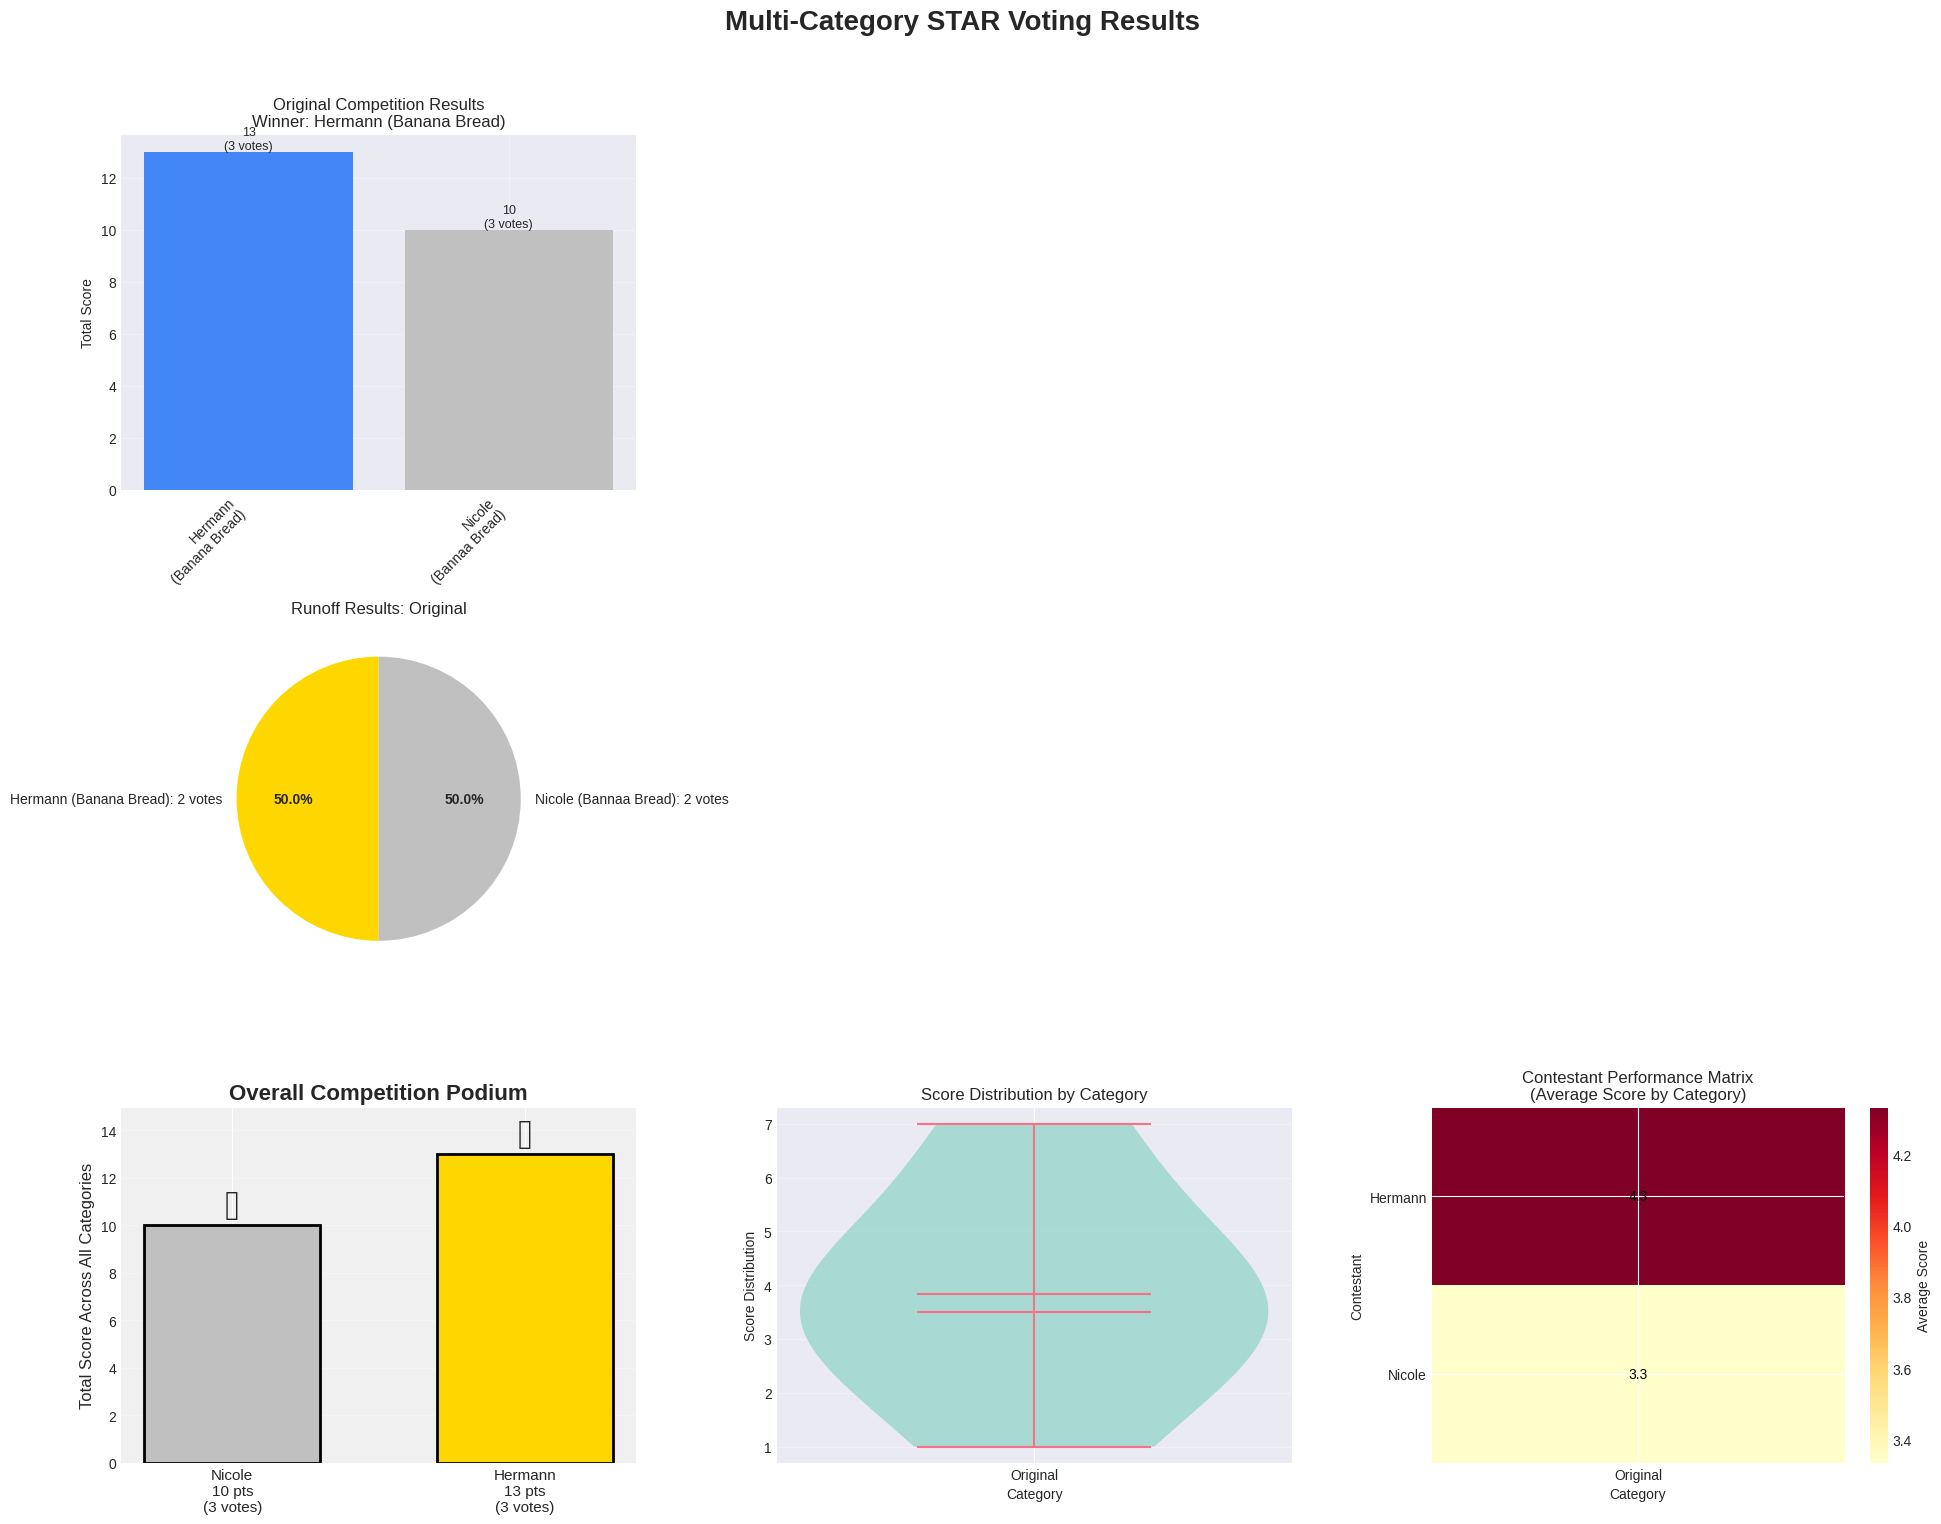

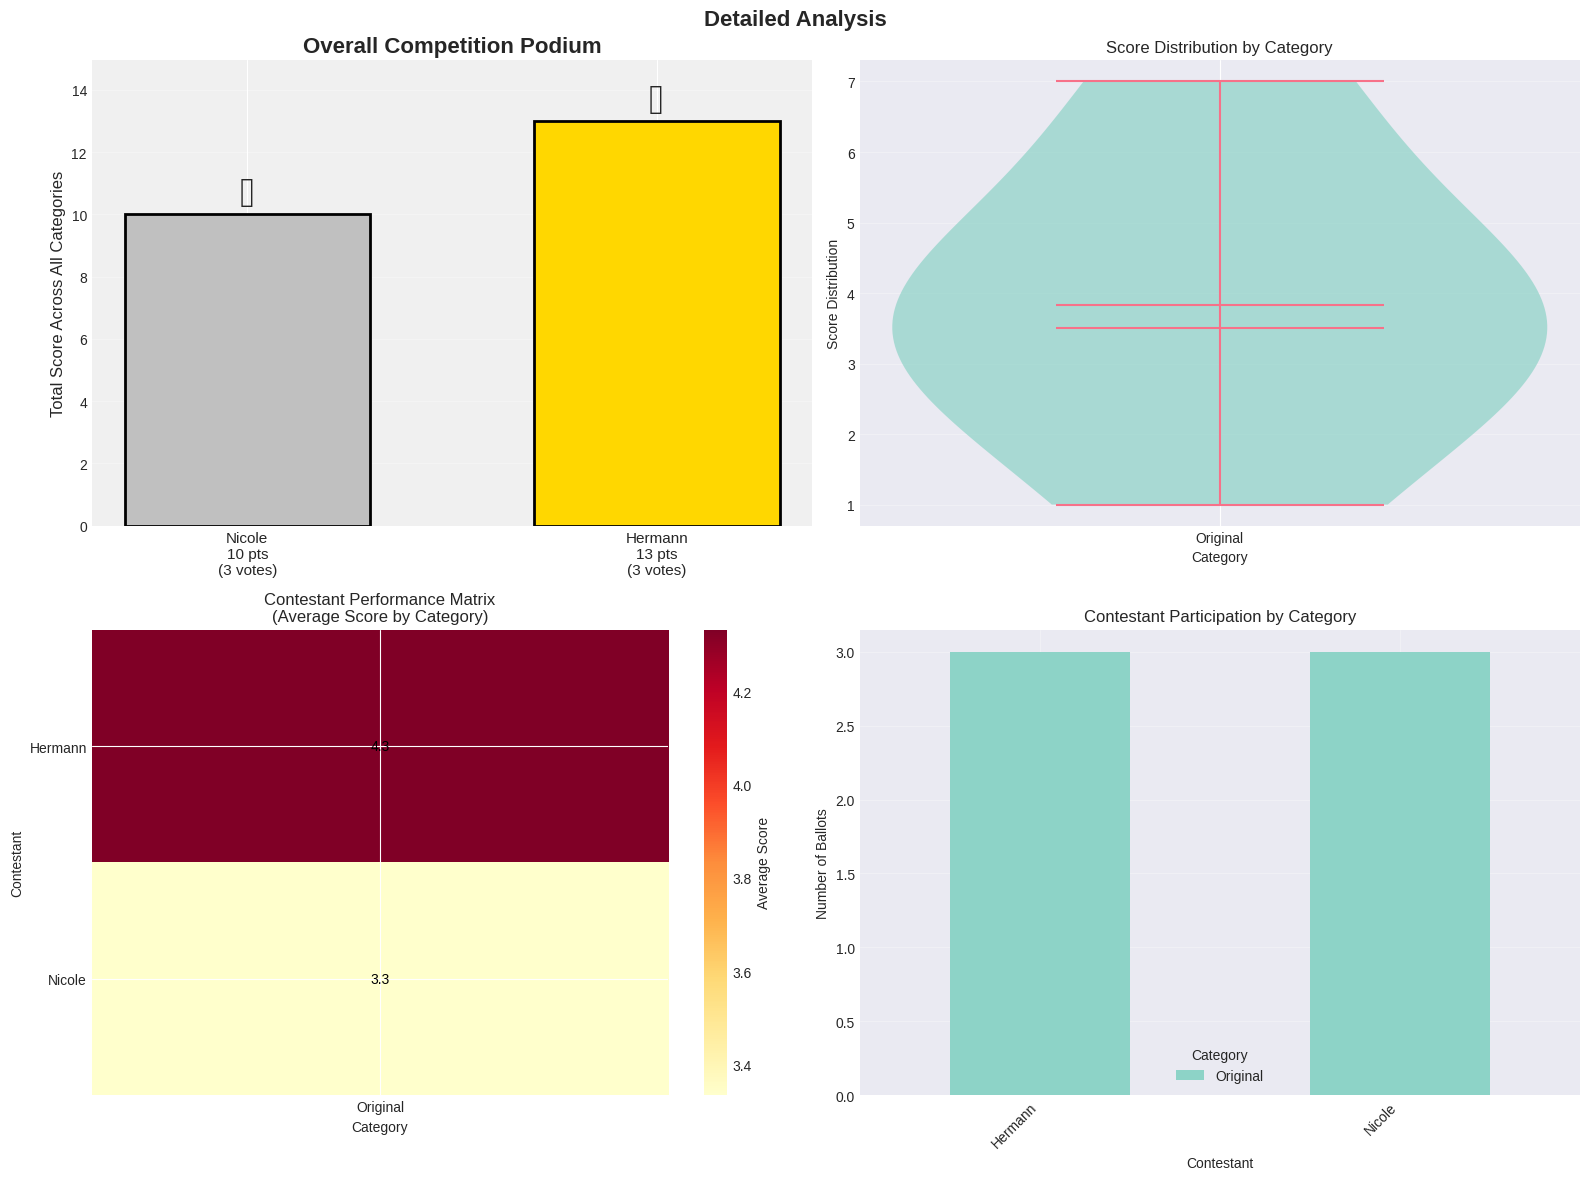

{'ballots':     BallotID Contestant ContestantLabel RaceCategory  Score
 0  Voter_001    Hermann    Banana Bread     Original      5
 1  Voter_001     Nicole    Bannaa Bread     Original      3
 2  Voter_002    Hermann    Banana Bread     Original      7
 3  Voter_003    Hermann    Banana Bread     Original      1
 4  Voter_003     Nicole    Bannaa Bread     Original      3
 5  Voter_004     Nicole    Bannaa Bread     Original      4,
 'race_results': {'Original': {'winner': 'Hermann (Banana Bread)',
   'winner_contestant': 'Hermann',
   'winner_method': 'Runoff tie - higher total score',
   'total_scores':   Contestant ContestantLabel  TotalScore  NumBallots
   0    Hermann    Banana Bread          13           3
   1     Nicole    Bannaa Bread          10           3,
   'runoff_details': {'winner': 'Hermann (Banana Bread)',
    'winner_data': Contestant              Hermann
    ContestantLabel    Banana Bread
    TotalScore                   13
    NumBallots                    3
  

In [58]:
run_complete_election_with_viz(banana_bread_actual_results_df)